## Script for integrity checking of the OPM triggers sent by DataPixx

### Import the necessary modules
Below are the required Python modules to be imported

In [1]:
from pprint import pprint
import mne
import json
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'
using_events_csv = True  

data_path='/home/rakshita/rds_folders/Sproject3/OPM_data'
bids_root = op.join(data_path, "Sub1_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=meg_suffix, extension=meg_extension, root=bids_root)

#### Retrieve the raw file

In [3]:
raw = read_raw_bids(bids_path=bids_path, verbose=False, 
                     extra_params={'preload':True})

#### print the essential information of the recorded file.

In [4]:
print(raw.info)

<Info | 18 non-empty values
 bads: []
 ch_names: L102_bz-s73, L104_bz-s80, L106_bz-s84, L108_bz-s77, L110_bz-s76, ...
 chs: 70 Magnetometers, 1 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 6 items (3 Cardinal, 3 HPI)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 gantry_angle: 0.0
 highpass: 0.0 Hz
 line_freq: 0.0
 lowpass: 250.0 Hz
 meas_date: 1997-06-23 16:12:26 UTC
 meas_id: 4 items (dict)
 nchan: 71
 proj_id: 1 item (ndarray)
 proj_name: mne_anonymize
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
 xplotter_layout: None
>


#### Integrity checking of the triggers using different parameters

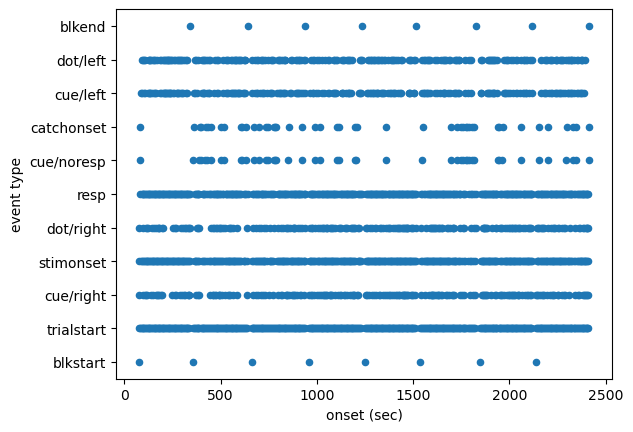

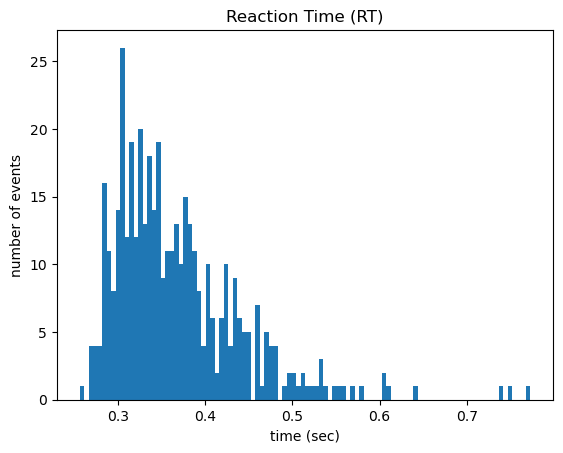

In [5]:
# Check if using an events CSV file or annotations
using_events_csv = True
if using_events_csv == False:
    events, events_id = mne.events_from_annotations(raw, event_id='auto')
        
elif using_events_csv:
    events_bids_path = bids_path.copy().update(suffix=events_suffix,
                                               extension=events_extension)
    meg_events_path = op.join(events_bids_path.directory, 'meg', events_bids_path.basename)
    events_file = pd.read_csv(meg_events_path, sep='\t')
    event_onsets = events_file[['onset', 'value', 'trial_type']]
    
    # Scatter plots of the events
    event_onsets.plot(kind='scatter', x='onset', y='trial_type')
    plt.xlabel('onset (sec)')
    plt.ylabel('event type')
    plt.show()
    
    # Concatenate all right and left trials (dots appearing on the gratings)
    dot_onset = np.concatenate([
        event_onsets.loc[event_onsets['trial_type'] == 'dot/right', 'onset'].to_numpy(),
        event_onsets.loc[event_onsets['trial_type'] == 'dot/left', 'onset'].to_numpy()
    ])
    dot_onset.sort() # Sorting as per occurance

    ## Find the instance of user response
    resp_onset = event_onsets.loc[event_onsets['trial_type'] == 'resp', 'onset'].to_numpy()

    # For calculating the reaction time of the user, consider only the dots which are followed by user response.
    reaction_times = []

    for resp in resp_onset:
        # Find all dot_onset events that occurred before the current response
        preceding_dots = dot_onset[dot_onset < resp]
        
        if preceding_dots.size > 0:
            # Get the most recent dot_onset before the current response
            last_dot = preceding_dots[-1]
            # Calculate the reaction time
            reaction_time = resp - last_dot
            reaction_times.append(reaction_time)

    reaction_times = np.array(reaction_times)  # Array of Reaction Times

    # Plot histogram of reaction times
    fig, ax = plt.subplots()
    plt.hist(reaction_times, bins=100)  # Adjust number of bins as needed
    plt.title("Reaction Time (RT)")
    plt.xlabel("time (sec)")
    plt.ylabel("number of events")
    plt.show()

    # Run the following codes to save the reaction times in a dataframe
    #reaction_times_df = pd.DataFrame({'reaction_time': reaction_times})
    #print(reaction_times_df)


#### Bar plot of the events based on Datapixx triggers

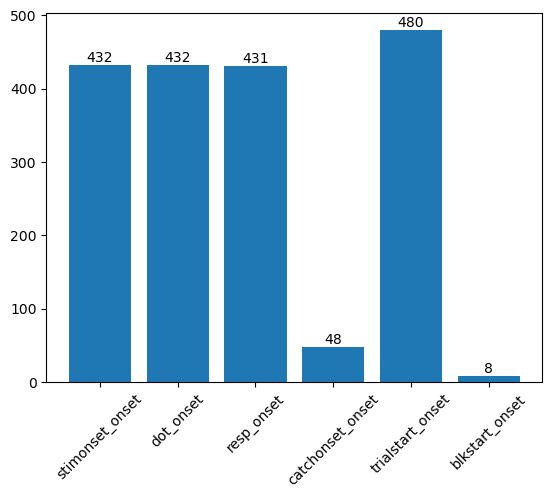

In [6]:
# Define event names
durations_onset = ['cue/right', 'cue/left','catchonset', 'stimonset', 'resp','trialstart','blkstart']
events_dict = {}
    
# Create dictionary with events matching with the event .csv file
for dur in durations_onset:
    events_dict[dur + "_onset"] = event_onsets.loc[event_onsets['trial_type'] == dur, 'onset'].to_numpy()

events_dict['dot_onset'] = dot_onset
    
# Count the number of each event
numbers_dict = {}
for numbers in [ 'stimonset_onset', 'dot_onset', 'resp_onset','catchonset_onset','trialstart_onset','blkstart_onset']:
    numbers_dict[numbers] = len(events_dict.get(numbers, []))
        
# Bar Plot of each event
fig, ax = plt.subplots()
bars = ax.bar(range(len(numbers_dict)), list(numbers_dict.values()))
plt.xticks(range(len(numbers_dict)), list(numbers_dict.keys()), rotation=45)
ax.bar_label(bars)
plt.show()